# Super resolution
This notebook tries to repeat the result of [this article](https://arxiv.org/pdf/1511.04587.pdf "Accurate Image Super-Resolution Using Very Deep Convolutional Networks")

## Preparation

In [8]:
import numpy as np
import pandas as pd
import matplotlib 
import caffe
from matplotlib import pyplot as plt
%matplotlib inline

### Prepare dataset

### Train

In [2]:
import os
folder = 'datasets/berkley/BSDS300/images/train/reducedx2/'
originals = [os.path.join(folder,f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder,f)) if 'reducedx2' not in f]
reducedx2 = [os.path.join(folder,f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder,f)) if 'reducedx2' in f]

In [3]:
print(os.path.basename(originals[0]))
print(os.path.basename(reducedx2[0]))

196015.jpg
reducedx2-109034.jpg


In [4]:
print(len(originals))
print(len(reducedx2))

200
200


In [5]:
import lmdb
from PIL import Image

in_db = lmdb.open('berkley-train-image-lmdb-srcnn', map_size=int(1e12))
with in_db.begin(write=True) as in_txn:
    for in_idx, in_ in enumerate(reducedx2):
        im = Image.open(in_) # load image:
        if im.height < im.width:
            im = im.resize((493, 333), Image.BICUBIC) #40 pixels bigger because of convolutions
        else:
            im = im.resize((333, 493), Image.BICUBIC)
        im = np.array(im) # - as np.uint8 {0, ..., 255}
        im = im[:,:,::-1] # - in BGR (switch from RGB)
        im = im.transpose((2,0,1)) # - in Channel x Height x Width order (switch from H x W x C)
        im_dat = caffe.io.array_to_datum(im)
        in_txn.put('{:0>10d}'.format(in_idx), im_dat.SerializeToString())
in_db.close()

orim_db = lmdb.open('berkley-train-orim-image-lmdb-srcnn', map_size=int(1e12))
with orim_db.begin(write=True) as in_txn:
    for in_idx, in_ in enumerate(reducedx2):

        orim = None
        for original_path in originals:
            if '-'+os.path.basename(original_path) in os.path.basename(in_):
                orim = original_path
                break
        orim = np.array(Image.open(orim))
        orim = orim[:,:,::-1]
        orim = orim.transpose((2,0,1))
        
        im_res = caffe.io.array_to_datum(orim)
        in_txn.put('{:0>10d}'.format(in_idx), im_res.SerializeToString())
orim_db.close()

### Test

In [6]:
import os
folder = 'datasets/berkley/BSDS300/images/test/reducedx2/'
originals = [os.path.join(folder,f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder,f)) if 'reducedx2' not in f]
reducedx2 = [os.path.join(folder,f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder,f)) if 'reducedx2' in f]

In [7]:
print(os.path.basename(originals[0]))
print(os.path.basename(reducedx2[0]))

175032.jpg
reducedx2-216081.jpg


In [8]:
print(len(originals))
print(len(reducedx2))

100
100


In [9]:
import lmdb
from PIL import Image

in_db = lmdb.open('berkley-test-image-lmdb-srcnn', map_size=int(1e12))
with in_db.begin(write=True) as in_txn:
    for in_idx, in_ in enumerate(reducedx2):
        im = Image.open(in_) # load image:
        if im.height < im.width:
            im = im.resize((493, 333), Image.BICUBIC)
        else:
            im = im.resize((333, 493), Image.BICUBIC)
        im = np.array(im) # - as np.uint8 {0, ..., 255}
        im = im[:,:,::-1] # - in BGR (switch from RGB)
        im = im.transpose((2,0,1)) # - in Channel x Height x Width order (switch from H x W x C)
        im_dat = caffe.io.array_to_datum(im)
        in_txn.put('{:0>10d}'.format(in_idx), im_dat.SerializeToString())
in_db.close()

orim_db = lmdb.open('berkley-test-orim-image-lmdb-srcnn', map_size=int(1e12))
with orim_db.begin(write=True) as in_txn:
    for in_idx, in_ in enumerate(reducedx2):

        orim = None
        for original_path in originals:
            if '-'+os.path.basename(original_path) in os.path.basename(in_):
                orim = original_path
                break

        orim = np.array(Image.open(orim))
        orim = orim[:,:,::-1]
        orim = orim.transpose((2,0,1))
        
        im_res = caffe.io.array_to_datum(orim)
        in_txn.put('{:0>10d}'.format(in_idx), im_res.SerializeToString())
orim_db.close()

### Prepare model

In [2]:
caffe.set_mode_gpu()

In [3]:
from caffe import layers as L, params as P

def srcnn(lmdb1,lmdb2, batch_size, mean_file='abc'):
    n = caffe.NetSpec()
    
    n.data = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb1, ntop=1, transform_param={'scale':1/(256.0*256.0)})
    n.orim = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb2, ntop=1, transform_param={'scale':1/(256.0*256.0)})

    n.conv1 = L.Convolution(n.data, kernel_size=9,num_output=64, weight_filler=dict(type='gaussian', std=0.01))
    n.relu1 = L.ReLU(n.conv1, in_place=True)
    n.conv2 = L.Convolution(n.relu1, kernel_size=1, num_output=32, weight_filler=dict(type='gaussian', std=0.01))
    n.relu2 = L.ReLU(n.conv2, in_place=True)
    n.conv3 = L.Convolution(n.relu2, kernel_size=5, num_output=3, weight_filler=dict(type='gaussian', std=0.01))
    

    #n.crop1 = L.Crop(n.residue, n.conv20, axis=2, offset=40)
    #n.crop2 = L.Crop(n.crop1, axis=3, offset=40)
    
    n.loss =  L.EuclideanLoss(n.conv3, n.orim)
    return n.to_proto()

# Important parameters!
training_set_size = 200
testing_set_size = 100
train_batch_size = 10
test_batch_size = 10

In [4]:
with open('srcnn_auto_train_srcnn.prototxt', 'w+') as f:
    f.write(str(srcnn('berkley-train-image-lmdb-srcnn', 'berkley-train-orim-image-lmdb-srcnn', train_batch_size, 'means/srcnn_train_mean.binaryproto')))
    
with open('srcnn_auto_test_srcnn.prototxt', 'w+') as f:
    f.write(str(srcnn('berkley-test-image-lmdb-srcnn', 'berkley-test-orim-image-lmdb-srcnn', test_batch_size, 'means/srcnn_test_mean.binaryproto')))

In [ ]:
!cat srcnn_auto_train_srcnn.prototxt

In [ ]:
!cat srcnn_auto_train_srcnn.prototxt

In [ ]:
!cat srcnn_auto_solver_srcnn.prototxt

In [5]:
# initialize solver
solver = caffe.SGDSolver('srcnn_auto_solver_srcnn.prototxt')

In [6]:
# restore model from iteration x
solver.net.copy_from('snapshot/srcnn-3000.caffemodel')

In [ ]:
# define the structure of the model for the first time
model_def = 'srcnn_auto_train_srcnn.prototxt'
net = caffe.Net(model_def,
                caffe.TRAIN)

In [14]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (1, 3, 361, 521)),
 ('residue', (1, 3, 321, 481)),
 ('conv1', (1, 64, 359, 519)),
 ('conv2', (1, 64, 357, 517)),
 ('conv3', (1, 64, 355, 515)),
 ('conv4', (1, 64, 353, 513)),
 ('conv5', (1, 64, 351, 511)),
 ('conv6', (1, 64, 349, 509)),
 ('conv7', (1, 64, 347, 507)),
 ('conv8', (1, 64, 345, 505)),
 ('conv9', (1, 64, 343, 503)),
 ('conv10', (1, 64, 341, 501)),
 ('conv11', (1, 64, 339, 499)),
 ('conv12', (1, 64, 337, 497)),
 ('conv13', (1, 64, 335, 495)),
 ('conv14', (1, 64, 333, 493)),
 ('conv15', (1, 64, 331, 491)),
 ('conv16', (1, 64, 329, 489)),
 ('conv17', (1, 64, 327, 487)),
 ('conv18', (1, 64, 325, 485)),
 ('conv19', (1, 64, 323, 483)),
 ('conv20', (1, 3, 321, 481)),
 ('loss', ())]

In [15]:
# just print the weight sizes (we'll omit the biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (64, 3, 3, 3)),
 ('conv2', (64, 64, 3, 3)),
 ('conv3', (64, 64, 3, 3)),
 ('conv4', (64, 64, 3, 3)),
 ('conv5', (64, 64, 3, 3)),
 ('conv6', (64, 64, 3, 3)),
 ('conv7', (64, 64, 3, 3)),
 ('conv8', (64, 64, 3, 3)),
 ('conv9', (64, 64, 3, 3)),
 ('conv10', (64, 64, 3, 3)),
 ('conv11', (64, 64, 3, 3)),
 ('conv12', (64, 64, 3, 3)),
 ('conv13', (64, 64, 3, 3)),
 ('conv14', (64, 64, 3, 3)),
 ('conv15', (64, 64, 3, 3)),
 ('conv16', (64, 64, 3, 3)),
 ('conv17', (64, 64, 3, 3)),
 ('conv18', (64, 64, 3, 3)),
 ('conv19', (64, 64, 3, 3)),
 ('conv20', (3, 64, 3, 3))]

## Work

In [7]:
%%time

niter = 20000
test_interval = 1000
train_interval = 100
# losses will also be stored in the log
train_loss = np.zeros(int(np.ceil(niter / train_interval)))
test_loss = np.zeros(int(np.ceil(niter // test_interval)))
pictures_number = niter // test_interval
rowsnum = 10
picidx = 0
# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    # store the train loss
    if it % train_interval == 0:
        train_loss[it / train_interval] = solver.net.blobs['loss'].data
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        picidx += 1
        print 'Iteration', it, 'testing...'
        score = 0.0
        for test_it in range(testing_set_size // test_batch_size):
            solver.test_nets[0].forward()
            score = solver.test_nets[0].blobs['loss'].data
        test_loss[it // test_interval] = score


Iteration 0 testing...
Iteration 1000 testing...


KeyboardInterrupt: 

In [7]:
solver.test_nets[0].blobs['loss'].data

array(100761.375, dtype=float32)

## Other

In [7]:
# send results via email
#!/usr/bin/env python
# encoding: utf-8

import smtplib
from datetime import datetime


def noticeEMail(train_str, test_str, usr, psw, fromaddr, toaddr):
    """
    Sends an email message through GMail once the script is completed.  
    Developed to be used with AWS so that instances can be terminated 
    once a long job is done. Only works for those with GMail accounts.
    
    starttime : a datetime() object for when to start run time clock
    usr : the GMail username, as a string
    psw : the GMail password, as a string 
    
    fromaddr : the email address the message will be from, as a string
    
    toaddr : a email address, or a list of addresses, to send the 
             message to
    """

    
    # Initialize SMTP server
    server=smtplib.SMTP('smtp.gmail.com:587')
    server.starttls()
    server.login(usr,psw)
    
    # Send email
    senddate=datetime.strftime(datetime.now(), '%Y-%m-%d')
    subject="Your job is complete"
    m="Date: %s\r\nFrom: %s\r\nTo: %s\r\nSubject: %s\r\nX-Mailer: My-Mail\r\n\r\n" % (senddate, fromaddr, toaddr, subject)
    msg='''
    
    train: ''' + train_str + ''' 
    
    test ''' + test_str
    
    server.sendmail(fromaddr, toaddr, m+msg)
    server.quit()


if __name__ == '__main__':    
    # Fill these in with the appropriate info...
    usr='dem4064@gmail.com'
    # psw=''
    fromaddr='dem4064@gmail.com'
    toaddr='dmitriy.denisenko@phystech.edu'

    # Send notification email
    noticeEMail(np.array_str(train_loss), np.array_str(test_loss), usr, psw, fromaddr, toaddr)

NameError: name 'psw' is not defined

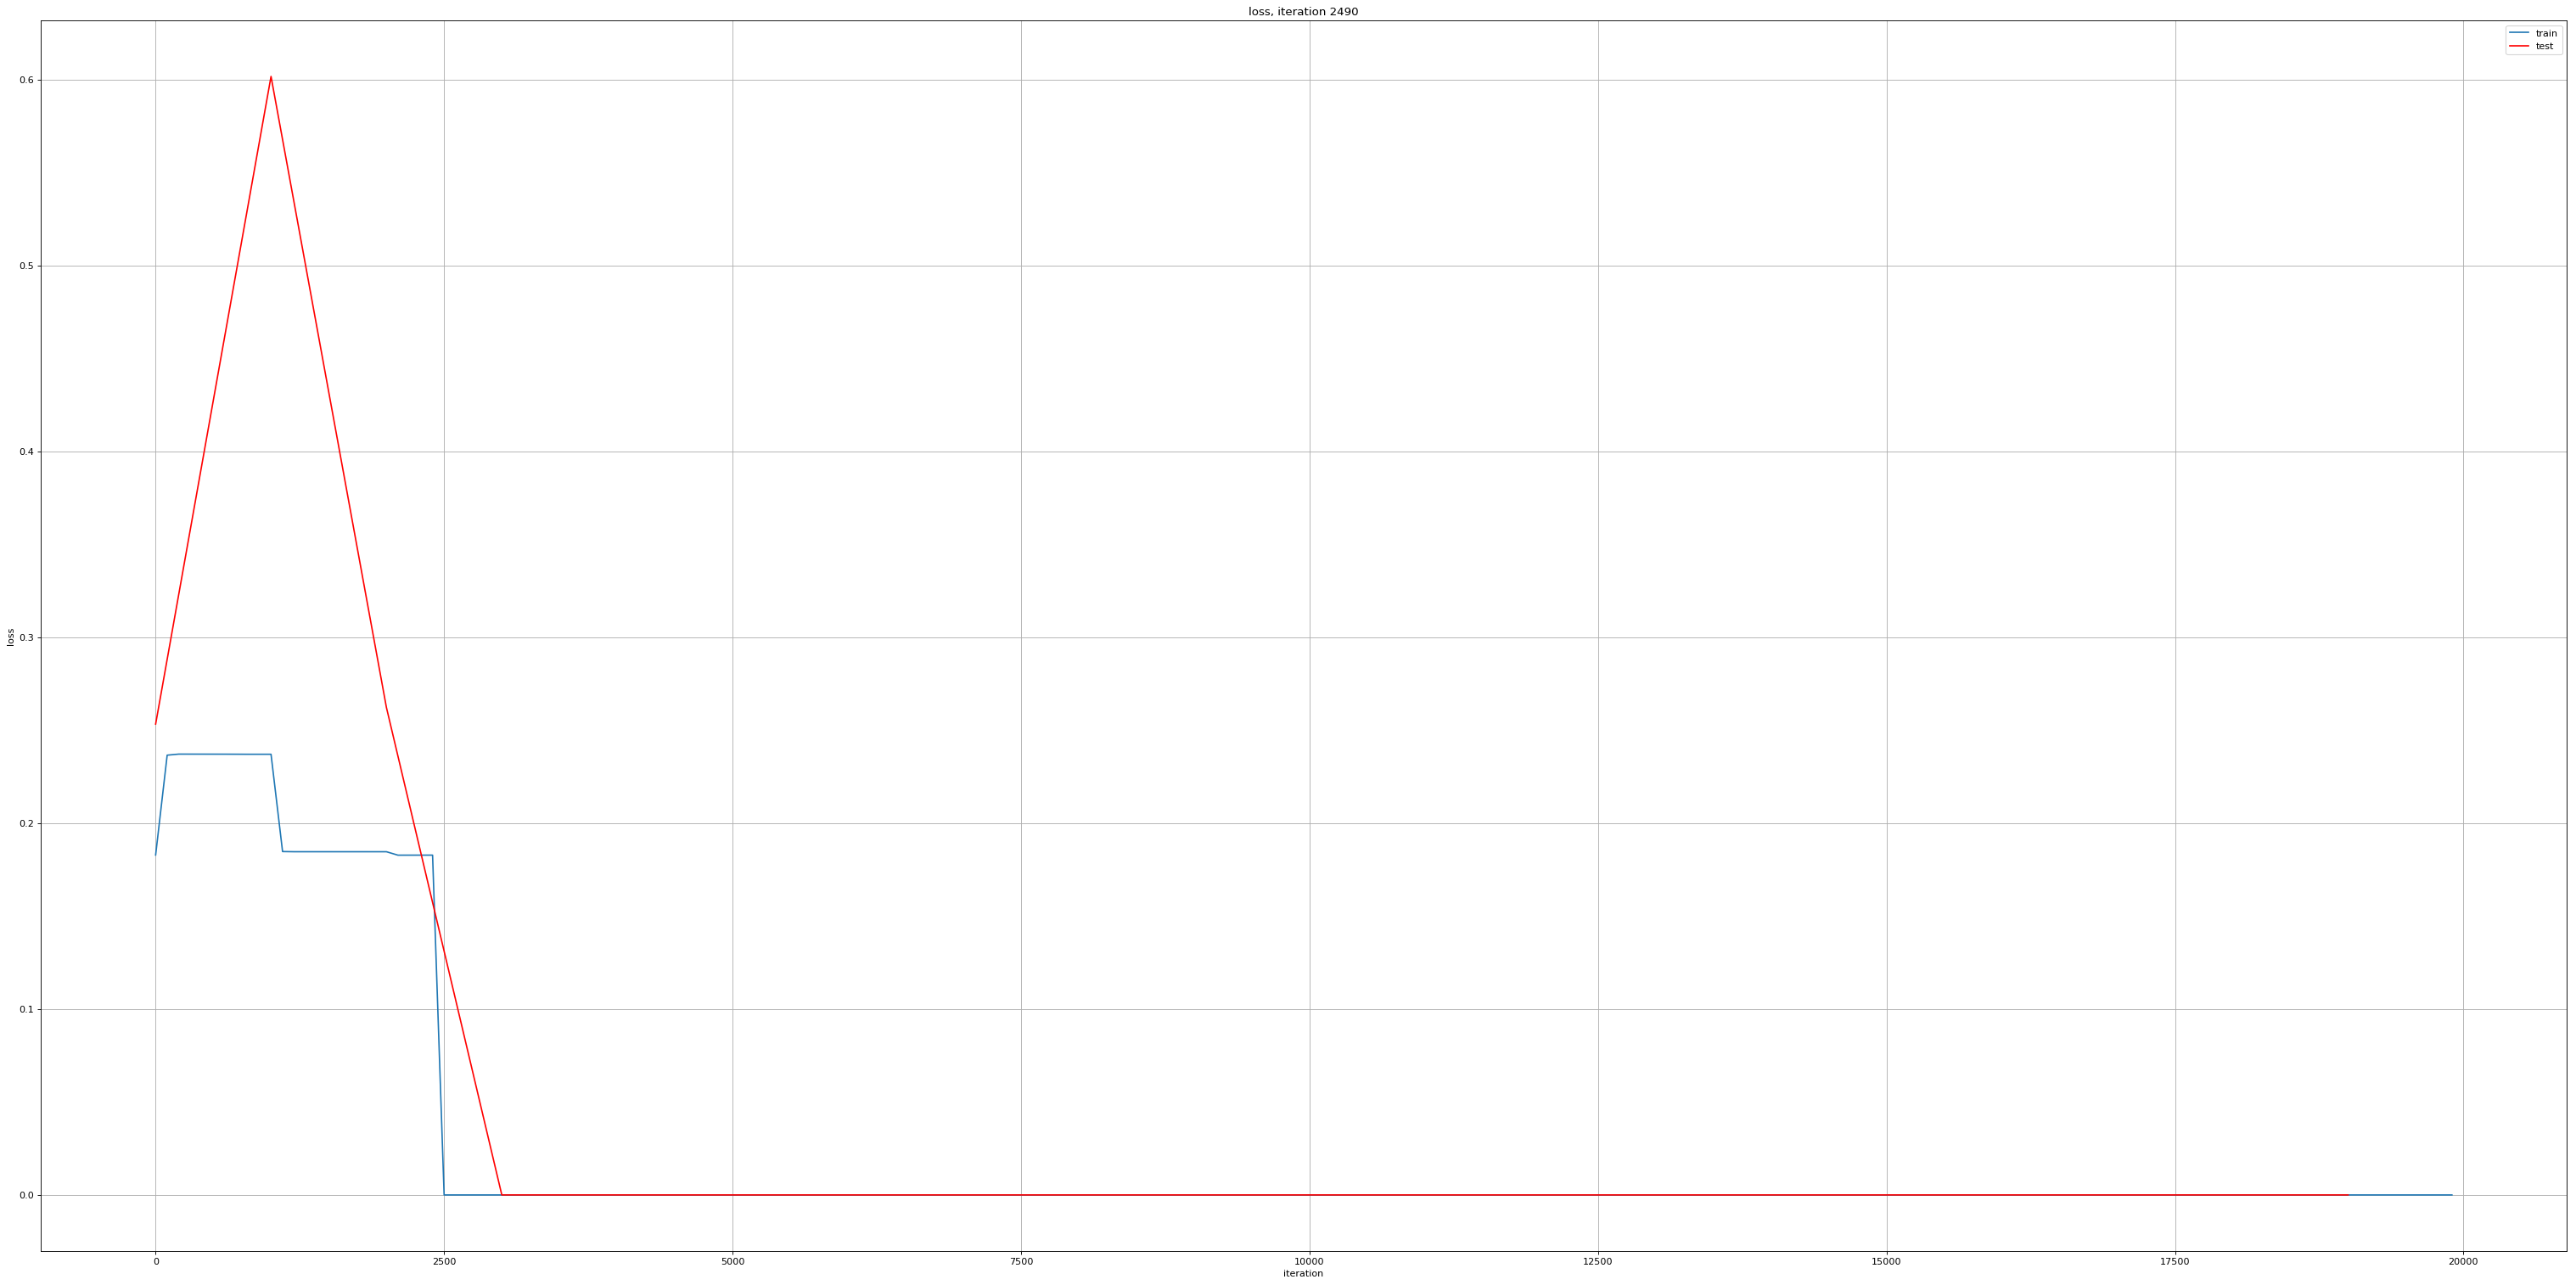

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(num=1, figsize=(48,24), dpi=80, facecolor='w', edgecolor='k')
plt.subplot()
plt.grid(True)
plt.plot(train_interval * np.arange(len(train_loss)), train_loss)
plt.plot(test_interval * np.arange(len(test_loss)), test_loss, 'r')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss, iteration %d' % it)
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
weights = 'snapshot/snap-srcnn.caffemodel'
model = 'srcnn_auto_train.prototxt'

net = caffe.Net(model, weights, caffe.TEST)

In [10]:
solver.test_nets[0].blobs['conv3'].data

array([[[ -4.17183677e-04,  -4.17841569e-04,  -4.20363824e-04, ...,
          -4.34066373e-04,  -4.35508700e-04,  -4.37079492e-04],
        [ -4.19656717e-04,  -4.19040094e-04,  -4.20864526e-04, ...,
          -4.35323920e-04,  -4.35247144e-04,  -4.37755079e-04],
        [ -4.22127894e-04,  -4.23485733e-04,  -4.24535567e-04, ...,
          -4.40115575e-04,  -4.41251264e-04,  -4.41136945e-04],
        ..., 
        [ -9.05431589e-05,  -8.82067470e-05,  -9.41019171e-05, ...,
          -1.95186934e-04,  -1.64876910e-04,  -8.51270015e-05],
        [ -8.06828757e-05,  -7.07357613e-05,  -8.04632946e-05, ...,
          -1.84643912e-04,  -1.29658802e-04,  -9.18739388e-05],
        [ -7.22426921e-05,  -6.72766473e-05,  -7.70678744e-05, ...,
          -1.57149567e-04,  -7.81891649e-05,  -5.89261836e-05]],

       [[ -4.54771303e-04,  -4.56895039e-04,  -4.55480418e-04, ...,
          -4.82432311e-04,  -4.79562208e-04,  -4.79974435e-04],
        [ -4.55182657e-04,  -4.57413378e-04,  -4.55701869e-0

In [13]:
solver.test_nets[0].blobs['orim'].data

array([[[[ 0.39453125,  0.39453125,  0.39453125, ...,  0.4140625 ,
           0.4140625 ,  0.4140625 ],
         [ 0.3984375 ,  0.3984375 ,  0.3984375 , ...,  0.41796875,
           0.41796875,  0.41796875],
         [ 0.40234375,  0.40625   ,  0.40625   , ...,  0.42578125,
           0.4296875 ,  0.4296875 ],
         ..., 
         [ 0.05078125,  0.0234375 ,  0.0234375 , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.02734375,  0.        ,  0.        , ...,  0.19921875,
           0.16796875,  0.13671875],
         [ 0.        ,  0.02734375,  0.046875  , ...,  0.0703125 ,
           0.125     ,  0.09375   ]],

        [[ 0.265625  ,  0.265625  ,  0.265625  , ...,  0.28515625,
           0.28515625,  0.28515625],
         [ 0.26953125,  0.26953125,  0.26953125, ...,  0.2890625 ,
           0.2890625 ,  0.2890625 ],
         [ 0.2734375 ,  0.27734375,  0.27734375, ...,  0.28515625,
           0.2890625 ,  0.2890625 ],
         ..., 
         [ 0.125     ,  0.078125